In [1]:
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D # to add convolutional layers
from keras.layers.convolutional import MaxPooling2D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers
from keras.layers import Dropout # to avoid overfitting
from keras.layers import Activation

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['val_loss'][-1]
    acc = history.history['val_acc'][-1]
    plt.title('Validation Loss: %.3f, Validation Accuracy: %.3f' % (loss, acc))

In [5]:
train_df = pd.read_csv('train.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df = pd.read_csv('test.csv')
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
columns = train_df.columns
X = train_df[columns[columns != 'label']]
y = train_df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 4)

In [9]:
X_train.shape

(37800, 784)

In [10]:
X_test.shape

(4200, 784)

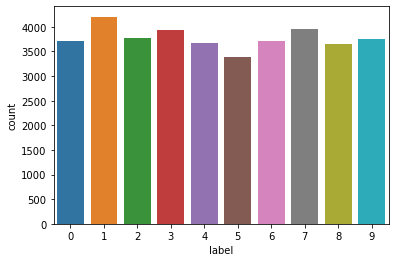

In [11]:
sns.countplot(y_train)

In [12]:
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [13]:
X_train = X_train / 255 # normalize training data
X_test = X_test / 255 # normalize test data

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1] # number of categories

In [15]:
def convolutional_model():
    ADAMAX = optimizers.Adamax(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999)
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), activation = 'relu', input_shape = (28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (2, 2), activation = 'relu'))
    model.add(Conv2D(256, (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    # Compile model
    model.compile(optimizer = ADAMAX, loss = 'categorical_crossentropy',  metrics = ['accuracy'])
    return model

In [16]:
gen = ImageDataGenerator(rotation_range = 12, width_shift_range = 0.1, shear_range = 0.1,
                         height_shift_range = 0.1, zoom_range = 0.1, fill_mode = 'nearest', horizontal_flip = False,
                         vertical_flip = False, featurewise_center = False,
                         samplewise_center = False, featurewise_std_normalization = False,
                         samplewise_std_normalization = False)
test_gen = ImageDataGenerator()

# Create batches to  train models faster
train_generator = gen.flow(X_train, y_train, batch_size = 32)
test_generator = test_gen.flow(X_test, y_test, batch_size = 32)

In [17]:
# Use annelar to gradually decrese the learning rate to improve generalization

reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.4, min_lr = 0.00002,
                                            mode = 'auto', cooldown = 0)

Epoch 1/32
2500/2500 [==============================] - 415s 166ms/step - loss: 0.2670 - acc: 0.9177 - val_loss: 0.0503 - val_acc: 0.9849
Epoch 2/32
2500/2500 [==============================] - 399s 160ms/step - loss: 0.1048 - acc: 0.9680 - val_loss: 0.0471 - val_acc: 0.9871
Epoch 3/32
2500/2500 [==============================] - 394s 158ms/step - loss: 0.0795 - acc: 0.9764 - val_loss: 0.0281 - val_acc: 0.9915
Epoch 4/32
2500/2500 [==============================] - 398s 159ms/step - loss: 0.0647 - acc: 0.9802 - val_loss: 0.0233 - val_acc: 0.9944
Epoch 5/32
2500/2500 [==============================] - 400s 160ms/step - loss: 0.0577 - acc: 0.9831 - val_loss: 0.0312 - val_acc: 0.9928
Epoch 6/32
2500/2500 [==============================] - 403s 161ms/step - loss: 0.0533 - acc: 0.9842 - val_loss: 0.0240 - val_acc: 0.9936
Epoch 7/32
2500/2500 [==============================] - 405s 162ms/step - loss: 0.0468 - acc: 0.9860 - val_loss: 0.0257 - val_acc: 0.9924

Epoch 00007: ReduceLROnPlateau re

<Figure size 576x432 with 0 Axes>

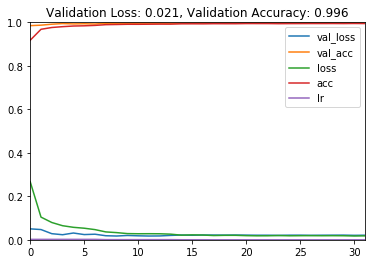

In [18]:
# build the model
model = convolutional_model()
epochs = 32
# fit the model

#history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 200, verbose = 2)

history = model.fit_generator(train_generator, steps_per_epoch = 40000//16, epochs = epochs, 
                              validation_data = test_generator, validation_steps = 10000//8, verbose = 1,
                              callbacks=[reduce_lr])

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))
plot_loss_accuracy(history)

Confusion matrix, without normalization
[[411   0   0   0   0   0   0   0   0   0]
 [  0 478   0   0   0   0   0   1   0   0]
 [  1   0 395   0   0   0   0   0   0   0]
 [  0   0   1 409   0   0   0   0   1   1]
 [  0   0   0   0 397   0   0   0   0   1]
 [  0   0   0   1   0 405   0   0   0   0]
 [  0   0   0   0   0   0 417   0   1   0]
 [  0   0   2   0   1   0   0 444   0   0]
 [  0   0   2   1   1   0   0   0 398   1]
 [  1   0   0   0   0   0   0   0   0 429]]


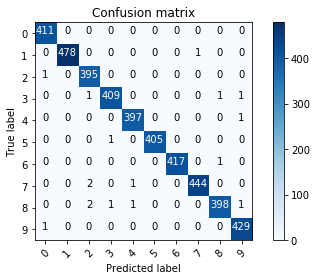

In [19]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
Y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(Y_true, y_pred)
plot_confusion_matrix(cm, classes = range(10))

In [20]:
test_data = test_df.values.reshape(test_df.shape[0], 28, 28, 1).astype('float32')
test_data = test_data / 255
Y_pred = model.predict(test_data)

In [21]:
Y_pred = np.argmax(Y_pred,axis = 1)
Y_pred = pd.Series(Y_pred, name = "Label")

In [22]:
submission_df = pd.DataFrame({
                  "ImageId": pd.Series(range(1, len(Y_pred)+1)),
                  "Label": pd.Series(Y_pred)})

In [23]:
submission_df.to_csv('submission_6.csv', index = False)